# AMR SKID-STEERING PROJECT
### Notebook contents
* RRT* + steer implementation (motion planning)
* RRT* implementation (only path planning)
* Controller of skid-steering Robot, useful for the steering computation
### Notebook contributors
* Mattia Castelmare
* Andrea Giuseppe Di Francesco
* Enrico Fazzi

In [1]:
import numpy as np
import math
from env import *
from plotting import *
import copy
from utils import *
import matplotlib.pyplot as plt


## RRT* NO steer (Geometric RRT*)
* In this cell there is a RRT* version, which is only path planning devoted

In [2]:
class RRT_STAR_path:
    def __init__(self, start, goal, env, step, prob_gs, n_iters, star = True):

        self.node_s = Node(start[0], start[1])
        self.node_g = Node(goal[0], goal[1])

        #########################################################

        self.env = env
        self.n_iters = n_iters
        # CHECK IF START NODE AND GOAL NODE IN THE ENV......
        self.step = step
        self.prob_gs = prob_gs  # Empirical value
        self.utils = Utils()
        self.node_s.cost = 0
        self.Tree = [self.node_s]
        self.plotting = Plotting(self.node_s, self.node_g)
        self.star = star


    def planning(self):
        # ax = sns.heatmap(self.trav_map.T, linewidth=0.5)
        # plt.show()
        for iter in range(self.n_iters):
            if iter % 100 == 0:
                print("ITERATION OF PLANNING N°: ",iter)
          
            n_rand = self.sample()
            n_nearest, n_new = self.compute_NN(n_rand)

            if n_nearest.x == n_new.x and n_nearest.y == n_new.y:
                continue
            
            if not self.utils.is_collision(n_nearest, n_new) and int(n_new.x) in range(0, self.env.x_range[-1]) and int(n_new.y) in range(0, self.env.y_range[-1]):
                # Assign to node velocity, acceleration and commands

                N_near = self.Tree#self.compute_NN(n_new, near=True)
                if self.star:
                    n_min, cost_min = self.choose_parent(N_near, n_nearest, n_new)
                else:
                    n_min = n_nearest
                    cost_min = n_nearest.cost + self.compute_cost(n_nearest, n_new)

                n_new.parent = n_min
                n_new.cost = cost_min
                # Insert Node
                self.Tree.append(n_new)
                if self.star:
                    self.rewire(N_near, n_min, n_new)

        path = [[self.node_g]]
        goal_state = self.get_goal_state()
        print('ERROR IS: ', self.compute_dist_NN(self.node_g, goal_state))

        self.tot_path = self.compute_path(path, goal_state)

        title = "RRT*, N = " + str(self.n_iters) if self.star else "RRT, N = " + str(self.n_iters)

        self.plotting.animation(self.Tree, self.tot_path,
                                title, steer=False)
    def choose_parent(self, N_near, n_nearest, n_new):
        n_parent = n_nearest
        # Init. guess parent for sampled node
        cost_min = n_nearest.cost + self.compute_cost(n_nearest, n_new)

        for n_near in N_near:
            if n_near.x == n_new.x and n_near.y == n_new.y:
                continue

            if not self.utils.is_collision(n_near, n_new) and int(n_new.x) in range(0, self.env.x_range[-1]) and int(n_new.y) in range(0, self.env.y_range[-1]):

                inter_cost = n_near.cost + \
                    self.compute_cost(n_near, n_new)  # Intermediate cost
                if n_new.cost != None:
                    if inter_cost < n_new.cost and inter_cost < cost_min:
                        n_parent = n_near         # New best alternative
                        cost_min = inter_cost


                else:
                    if inter_cost < cost_min:
                        n_parent = n_near         # New best alternative
                        cost_min = inter_cost

        return n_parent, cost_min

    def rewire(self, N_near, n_parent, n_new):
        for n_near in N_near:
            if n_near.x == n_parent.x and n_near.y == n_parent.y:
                continue

            if n_near.x == n_new.x and n_near.y == n_new.y:
                continue


            if not self.utils.is_collision(n_near, n_new) and int(n_near.x) in range(0, self.env.x_range[-1]) and int(n_near.y) in range(0, self.env.y_range[-1]):

                if n_new.cost + self.compute_cost(n_near, n_new) < n_near.cost:

                    n_near_old_idx = self.Tree.index(n_near)
                    n_near.parent = n_new
                    n_near.cost = n_new.cost + self.compute_cost(n_near, n_new)
                    self.Tree[n_near_old_idx] = n_near

        return

    def compute_NN(self, n_curr, near=False):

        # CHECK COLLISION
        dist_list = np.array([self.compute_dist(n_curr, n_tree)
                             for n_tree in self.Tree])

        if not near:  # Nearest

            n_nearest = self.Tree[np.argmin(dist_list)]
            dist = min(np.min(dist_list), self.step)
            theta = math.atan2(n_curr.y-n_nearest.y, n_curr.x - n_nearest.x)
            n_new = Node(n_nearest.x + dist*math.cos(theta),
                         n_nearest.y + dist*math.sin(theta))

            return n_nearest, n_new
        else:        # Near
            node_list = [self.Tree[idx] for idx in range(
                len(dist_list)) if dist_list[idx] < self.radius]

            return node_list

    def sample(self):
        ''' Sample function RRT*, sample the goal node with a low probability '''
        if np.random.random() > self.prob_gs:
            x_new = np.random.uniform(self.env.x_range[-1])
            y_new = np.random.uniform(self.env.y_range[-1])
            return Node(x_new, y_new)

        return self.node_g

    def get_goal_state(self):

        dist_list = np.array([self.compute_dist(node, self.node_g)
                             for node in self.Tree])
        min_idx = np.argmin(dist_list)
        goal_state = self.Tree[min_idx]

        return goal_state

    def compute_path(self, path, goal_state):

        n_curr = goal_state
        while n_curr.x != self.node_s.x and n_curr.y != self.node_s.y:
            path.append([n_curr])
            n_curr = n_curr.parent
        path.append([n_curr])

        return path

    def compute_dist(self, n1, n2):
        dist = math.sqrt((n1.x-n2.x)**2 + (n1.y-n2.y)**2)
        return dist
    
    def compute_dist_NN(self, n1, n2):
        dist = math.sqrt((n1.x-n2.x)**2 + (n1.y-n2.y)**2)
        return dist

    def compute_cost(self, n1, n2):
 
        cost = plan_dist = self.compute_dist(n1, n2)  # Planar distance

        return cost

## SIMULATION

In [5]:
# Environment initialization #
env = Env(x_bounds=x_bounds, y_bounds=y_bounds)

start = 2, 2
goal = 45, 25 
star = True
n_iters = 2000
### MOTION PLANNING ###
rrt = RRT_STAR_path(start, goal, env, step, prob_gs, n_iters, star) 

### ONLY PATH PLANNING ###
# rrt = RRT_STAR_path(start, goal, env, step, prob_gs, n_iters) 


ITERATION OF PLANNING N°:  0
ITERATION OF PLANNING N°:  100
ITERATION OF PLANNING N°:  200
ITERATION OF PLANNING N°:  300
ITERATION OF PLANNING N°:  400
ITERATION OF PLANNING N°:  500
ITERATION OF PLANNING N°:  600
ITERATION OF PLANNING N°:  700
ITERATION OF PLANNING N°:  800
ITERATION OF PLANNING N°:  900
ITERATION OF PLANNING N°:  1000
ITERATION OF PLANNING N°:  1100
ITERATION OF PLANNING N°:  1200
ITERATION OF PLANNING N°:  1300
ITERATION OF PLANNING N°:  1400
ITERATION OF PLANNING N°:  1500
ITERATION OF PLANNING N°:  1600
ITERATION OF PLANNING N°:  1700
ITERATION OF PLANNING N°:  1800
ITERATION OF PLANNING N°:  1900
ERROR IS:  0.0


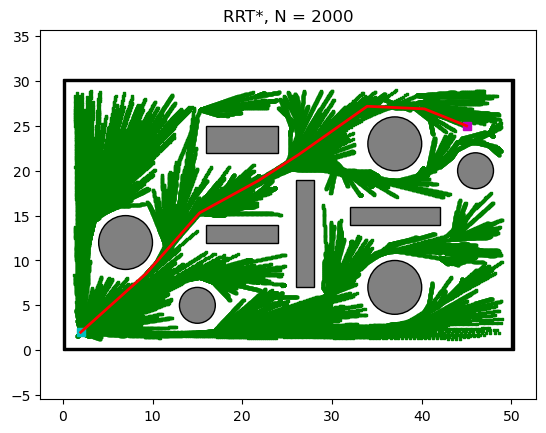

In [6]:
rrt.planning()